### Model Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import imdb

In [3]:
((XT,YT),(Xt,Yt)) = imdb.load_data()

17465344/17464789 [==============================] - 1s 0us/step


In [4]:
word_idx = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
idx_words = dict([value,key] for (key,value) in word_idx.items())

In [8]:
actual_review = ' '.join(idx_words.get(idx-3,'?') for idx in Xt[3])

In [9]:
print(type(XT))

<class 'numpy.ndarray'>


In [10]:
#Imports
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Vectorization
from nltk.tokenize import RegexpTokenizer

#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def stopwordRemoval(sen):
  sw = (stopwords.words('english'))
  useful = ['few','only','don',"don't",'not','but','if','until','or','while','by','about','against','below','above','up','down','off','again','when','both','no','such','nor',"dont't",'should',"should've"]
  sw = sw[:142]
  sw = [word for word in sw if word not in useful]
  sen = [word.lower() for word in sen if word.lower() not in sw]
  return sen

def stem(sen):
  ss = SnowballStemmer(language = ('english'))
  sen = [ss.stem(word) for word in sen] 
  return sen

#preprocessing on trainingData

def vectorize(XT):                         #stopwordRemoval + Stemming + Vectorization
  corpus = []
  #Getting actual reviews 
  for i in XT:
    sen = ' '.join(idx_words.get(idx-3,'?') for idx in i)
    corpus.append(sen)
  

  tokenizer = RegexpTokenizer('[a-zA-Z\']+')   
  i = 0
  #Tokenization + StopwordRemoval + Stemming
  for sen in corpus:
    sen = tokenizer.tokenize(sen) 
    sen = stopwordRemoval(sen)
    sen = stem(sen)
    sen = ' '.join(word for word in sen)
    corpus[i] = sen
    i = i+1
  
  #Vectorization
  cv = CountVectorizer(max_features = 10000)
  vect = cv.fit_transform(corpus)
  vocab = cv.vocabulary_
  invVocab = dict(zip(vocab.values(), vocab.keys()))

  #Making new XTrain after preprocessing
  XVec = []
  for i in corpus:
    i = i.split()
    item = [vocab.get(key) for key in i if vocab.get(key) != None]
    XVec.append(item)

  XVec = np.array(XVec)
  return cv, XVec, vocab, invVocab


In [12]:
cv,XT_,vocab,invVocab = vectorize(XT)
#save vocab, invVocab

In [13]:
#Preprocessing on testingData

def preProcess(Xt,vocab):
  corpus = []
  #Getting actual reviews 
  for i in Xt:
    sen = ' '.join(idx_words.get(idx-3,'?') for idx in i)
    corpus.append(sen)
  

  tokenizer = RegexpTokenizer('[a-zA-Z\']+')   
  i = 0
  #StopwordRemoval + Stemming
  for sen in corpus:
    sen = tokenizer.tokenize(sen) 
    sen = stopwordRemoval(sen)
    #sen = stem(sen)
    sen = ' '.join(word for word in sen)
    corpus[i] = sen
    i = i+1
  
  XVec = []
  for i in corpus:
    i = i.split()
    item = [vocab.get(key) for key in i if vocab.get(key) != None]
    XVec.append(item)


  XVec = np.array(XVec)
  return XVec


In [14]:
#Call for testingData preprocessing
Xt_ = preProcess(Xt,vocab)

In [16]:
#saving voabulary(size : 10000)
filehandler = open('vocabFile.txt', 'wt')
data = str(vocab)
filehandler.write(data)

165946

##### Getting estimate of length of sentences

In [19]:
import matplotlib.pyplot as plt

119.7056


(array([ 2740., 11407.,  4808.,  2510.,  1379.,   845.,   498.,   308.,
          237.,   183.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 10 Patch objects>)

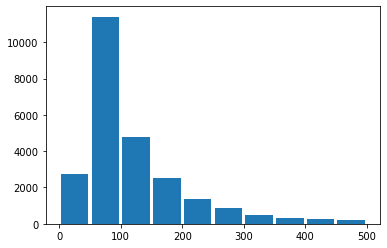

In [20]:
length = []
l = 0
i = 0
for vect in XT_:
  l += len(vect)
  length.append(len(vect))
  i += 1
print(l/i)
plt.hist(length,range = (0,500),rwidth = 0.9)

##### Padding sentences to a max length of 500

In [21]:
from tensorflow.keras.preprocessing import sequence
X_train = sequence.pad_sequences(XT_,maxlen = 500)
X_test = sequence.pad_sequences(Xt_, maxlen = 500)

In [22]:
from keras.utils import to_categorical
YT_ = to_categorical(YT)
Yt_ = to_categorical(Yt)

#### Making Neural Network model

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D

In [25]:
model = Sequential()
model.add(Embedding(10000,64))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(2,activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 652,482
Trainable params: 652,482
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Compiling model
model.compile(optimizer = "RMSProp", loss = 'categorical_crossentropy', metrics = ['acc'])
#For saving only the best weights for val_acc
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("sentimentModel.h5",monitor = 'val_loss',verbose = 0,save_best_only = True,save_weights_only = False, mode = 'auto',period = 1)
#Early stopping 
from keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor = 'val_acc',patience = 3)

In [27]:
hist = model.fit(X_train,YT_, validation_split = 0.1, epochs = 10, batch_size = 256, callbacks = [checkpoint, earlyStop])

Epoch 1/10
88/88 [==============================] - 10s 116ms/step - loss: 0.4748 - acc: 0.7950 - val_loss: 0.4357 - val_acc: 0.8332
Epoch 2/10
88/88 [==============================] - 9s 108ms/step - loss: 0.2714 - acc: 0.9010 - val_loss: 0.3154 - val_acc: 0.8852
Epoch 3/10
88/88 [==============================] - 9s 105ms/step - loss: 0.2101 - acc: 0.9266 - val_loss: 0.2904 - val_acc: 0.8836
Epoch 4/10
88/88 [==============================] - 9s 104ms/step - loss: 0.1751 - acc: 0.9383 - val_loss: 0.3111 - val_acc: 0.8844
Epoch 5/10
88/88 [==============================] - 9s 105ms/step - loss: 0.1514 - acc: 0.9479 - val_loss: 0.3266 - val_acc: 0.8772


In [28]:
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

##### Plotting model accuracy on training and testing data

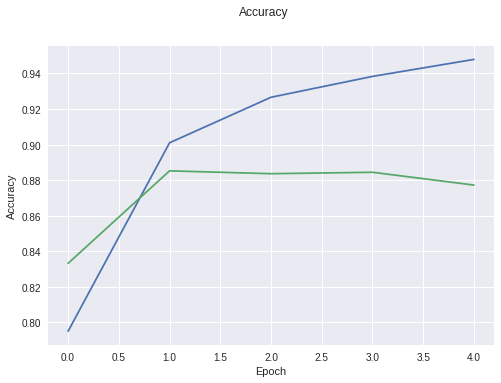

In [29]:
plt.style.use("seaborn")
fig = plt.figure()
fig.suptitle('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc,label = 'training_acc')
plt.plot(val_acc, label = 'val_acc')
plt.show()

In [31]:
import tensorflow as tf

In [32]:
#Evaluating model on testing data
loss, acc = model.evaluate(X_test,Yt_)

782/782 [==============================] - 24s 30ms/step - loss: 0.3554 - acc: 0.8656


In [33]:
#saving Model
model.save('sentimentModel.h5')

### Loading saved model and predicting

In [35]:
import numpy as np
import matplotlib.pyplot as plt

##### loadingModel

In [37]:
from tensorflow.keras import models

In [38]:
model = models.load_model('sentimentModel.h5')

In [39]:
#Making corpus with sample sentences
corpus = []
testSen = "He has sung it so beautifully. Amazing! They've done a great job"
corpus.append(testSen)
testSen = "Such a horrible post!"
corpus.append(testSen)
print(corpus)


["He has sung it so beautifully. Amazing! They've done a great job", 'Such a horrible post!']


In [40]:
import ast

In [41]:
#Importing vocabulary
f = open('vocabFile.txt', 'r') 
vocab = f.read()
vocab = ast.literal_eval(vocab)

In [43]:
#Imports

#Vectorization
from nltk.tokenize import RegexpTokenizer

#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

#padding
from tensorflow.keras.preprocessing import sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
def stopwordRemoval(sen):
  sw = (stopwords.words('english'))
  useful = ['few','only','don',"don't",'not','but','if','until','or','while','by','about','against','below','above','up','down','off','again','when','both','no','such','nor',"dont't",'should',"should've"]
  sw = sw[:142]
  sw = [word for word in sw if word not in useful]
  sw += ['cunt', 'wank', 'fuck', 'bastard', 'dick', 'cock', 'pussy', 'twat', 'tit', 'bitch', 'shit', 'ass', 'arse', 'crap', 'damn', 'nigga', 'nigger', 'porn', 'hooker', 'whore', 'hoe', 'cooch', 'slut', 'fap', 'jerk', 'fag', 'boob', 'darn'] 
  sen = [word.lower() for word in sen if word.lower() not in sw]
  return sen

def stem(sen):
  ss = SnowballStemmer(language = ('english'))
  sen = [ss.stem(word) for word in sen] 
  return sen

#### Preprocessing on Sample Input Sentences

In [46]:
def preProcessInput(corpus,vocab):
  tokenizer = RegexpTokenizer('[a-zA-Z\']+')   
  i = 0
  corpusCopy = corpus
  #StopwordRemoval + Stemming
  for sen in corpusCopy:
    sen = tokenizer.tokenize(sen) 
    sen = stopwordRemoval(sen)
    sen = stem(sen)
    corpus[i] = sen
    i = i+1
  
  XVec = []
  for i in corpusCopy:
    item = [vocab.get(key) for key in i if vocab.get(key) != None]
    XVec.append(item)


  XVec = np.array(XVec)
  XVec = sequence.pad_sequences(XVec,maxlen = 500)
  return XVec

In [47]:
XVec = preProcessInput(corpus,vocab)
print(corpus)

[['sung', 'beautifully', 'amazing', "they've", 'done', 'great', 'job'], ['such', 'horrible', 'post']]


#### Predicting

In [48]:
#predicting with model
np.argmax(model.predict(XVec),axis = 1)

array([1, 0])

#Insight on 2 sample sentences#

"He has sung it so beautifully. Amazing! They've done a great job" - label: 1(good)
"Such a horrible post!"  - label : 0(bad)